In [1]:
from os import environ
from getpass import getpass

def _set_env(var: str):
    if not environ.get(var):
        environ[var] = getpass(f"{var}: ")

_set_env("COHERE_API_KEY")

In [2]:
from langchain_cohere import ChatCohere
llm = ChatCohere(
    model="command-a-03-2025"
)

In [3]:
from __future__ import annotations

from typing import Optional, Literal, List
from typing_extensions import TypedDict, Annotated
from pydantic import BaseModel, Field

Beat = Literal["A", "B", "C", "D", "E"]

class UserInput(BaseModel):
    scholarship_name: str
    program_type: Literal["Undergrad", "Graduate","Community Leadership"]
    goal_one_liner: str
    resume_points: list[str]


class PiiSpan(BaseModel):
    start: int
    end: int
    pii_type: str
    confidence: Optional[float] = None


class BeatPlanItem(BaseModel):
    beat: Beat
    missing: list[str]
    guidance: Optional[str] = None


class QuestionObject(BaseModel):
    beat: Beat
    question: str
    intent: str
    
class BeatPlanOut(BaseModel):
    items: list[BeatPlanItem]

class QuestionsOut(BaseModel):
    items: list[QuestionObject]

class ValidationReport(BaseModel):
    ok: bool
    errors: list[str] = Field(default_factory=list)
    warnings: list[str] = Field(default_factory=list)
    repairs_applied: list[str] = Field(default_factory=list)


def merge_questions_by_beat(left: dict[Beat, List[QuestionObject]], right: dict[Beat, List[QuestionObject]]):
    out = dict(left or {})
    for beat, qs in (right or {}).items():
        out.setdefault(beat, []).extend(qs)
    return out

class PipelineState(TypedDict, total=False):
    # Inputs
    user_input: UserInput

    # Governance front gate
    canonical_input: str
    pii_spans: list[PiiSpan]
    redacted_input: str

    # Planning
    beat_plan: list[BeatPlanItem]

    # Map outputs (per beat)
    
    questions_by_beat: Annotated[dict[Beat, list[QuestionObject]], merge_questions_by_beat]

    # Reduce outputs
    final_questions_by_beat: dict[Beat, list[QuestionObject]]
    
    # Validation outputs
    failed_beats: list[Beat]
    failed_reasons: dict[Beat, list[str]]


    # Reliability / repair
    validation_report: ValidationReport
    attempt_count: int

    regen_request: list[Beat]

In [5]:
from presidio_analyzer import AnalyzerEngine
from presidio_anonymizer import AnonymizerEngine
from presidio_anonymizer.entities import OperatorConfig
from typing import Any

def _build_canonical_input(user_input: UserInput) -> str:
    """
    A helper to combine all the inputs together."""
    bullets = "\n".join(f"- {b}" for b in user_input.resume_points)
    return (
        f"Scholarship: {user_input.scholarship_name}\n"
        f"Program type: {user_input.program_type}\n"
        f"Goal: {user_input.goal_one_liner}\n"
        f"Resume points:\n{bullets}\n"
    )

def make_redactor_node(
    *,
    language: str = "en",
    entities: List[str] | None = None,
    default_operator: str = "replace",
) :
    """
    A presidio wrapper to create the redactor node.
    """
    analyzer = AnalyzerEngine()
    anonymizer = AnonymizerEngine()
    entities = entities or ["PERSON", "PHONE_NUMBER", "EMAIL_ADDRESS", "LOCATION", "CREDIT_CARD", "URL"]

    # Replace PII with its entity type,<EMAIL_ADDRESS>.
    # (Presidio supports different operators; replace/mask/redact, etc.) :contentReference[oaicite:4]{index=4}
    operators: dict[str, OperatorConfig] = {
        "DEFAULT": OperatorConfig(default_operator, {"new_value": "<REDACTED>"}),
        "EMAIL_ADDRESS": OperatorConfig("replace", {"new_value": "<EMAIL>"}),
        "PHONE_NUMBER": OperatorConfig("replace", {"new_value": "<PHONE>"}),
        "PERSON": OperatorConfig("replace", {"new_value": "<NAME>"}),
        "LOCATION": OperatorConfig("replace", {"new_value": "<LOCATION>"}),
        "URL": OperatorConfig("replace", {"new_value": "<URL>"}),
    }

    def redactor_node(state: "PipelineState") -> dict[str, Any]:
        user_input = state["user_input"]
        canonical = _build_canonical_input(user_input)

        results = analyzer.analyze(
            text=canonical,
            language=language,
            entities=entities,
        )

        pii_spans = [
            PiiSpan(
                start=r.start,
                end=r.end,
                pii_type=r.entity_type,
                confidence=float(r.score) if r.score is not None else None,
            )
            for r in results
        ]

        redacted = anonymizer.anonymize(
            text=canonical,
            analyzer_results=results,
            operators=operators,
        ).text

        return {
            "canonical_input": canonical,
            "pii_spans": pii_spans,
            "redacted_input": redacted,
            "attempt_count": state.get("attempt_count", 0),
            "questions_by_beat": state.get("questions_by_beat", {}),
        }

    return redactor_node


In [8]:
from typing import Literal
from langgraph.types import Command, Send
from langgraph.graph import START, END, StateGraph
from IPython.display import Image, display
from textwrap import dedent

def _beat_defs() -> str:
    return dedent("""\
    Beats:
    A: Purpose & Fit
    B: Excellence / Proof
    C: Impact
    D: Leadership & Character
    E: Reflection & Growth
    """)

def beat_planner_messages(redacted_input: str):
    system = dedent("""\
    You are a beat planner for an SOP question generator.
    Return structured data only. No prose.
    """)

    rules = dedent("""\
    Create a plan for beats A–E.

    For each beat output:
    - beat: one of A,B,C,D,E
    - missing: 2–4 short, specific missing details needed to write that beat,
      grounded in the redacted input (reference the section name when possible).
    - guidance: one actionable hint (<= 20 words).
    - anchors: 2–4 exact phrases copied verbatim from the redacted input (each <= 6 words)
      that are relevant to this beat.

    Constraints:
    - Include A,B,C,D,E exactly once.
    - If the input lacks anchors for a beat, set anchors=[] and put the needed specifics in missing.
    """)

    user_ctx = dedent(f"""\
    {_beat_defs()}
    Redacted canonical input (source of truth):
    {redacted_input}

    Return a beat plan.
    """)

    return [
        {"role": "system", "content": system},
        {"role": "user", "content": rules + "\n\n" + user_ctx},
    ]

from textwrap import dedent

def question_generator_messages(task, redacted_input: str):
    system = dedent("""\
    You generate tailored SOP questions.
    Return structured data only. No prose.
    """)

    regen_mode = bool(task.guidance and "Regenerate questions" in task.guidance)

    base_rules = dedent("""\
    Generate exactly 2 questions for the given beat.

    Output format:
    {
      "beat": "A|B|C|D|E",
      "questions": [
        {"q": "...?", "intent": "...", "anchor_used": "..."},
        {"q": "...?", "intent": "...", "anchor_used": "..."}
      ]
    }

    Constraints:
    - Structured data only.
    - Questions only: each q must be a single line ending with '?'.
    - Do NOT include any PII or placeholders like <NAME>, <EMAIL>, <PHONE>, [ORG_1].
    - intent must be <= 12 words and describe what the question tests.
    - beat must equal the provided beat.
    - Keep wording concise.
    - The two questions must be meaningfully different:
      * Q1: narrative/decision/tradeoff
      * Q2: evidence/validation/comparison/feedback signal
    """)

    grounding_rules = dedent("""\
    Grounding rules:
    - Do NOT introduce specific names, organizations, dates, locations, or numbers
      unless they appear verbatim in the provided redacted input.
    - If a specific detail is missing, ask for it instead of assuming it.
    """)

    anti_generic_rules = dedent("""\
    Anti-generic rules:
    - Each question must be anchored: it must include an exact short phrase from task.anchors
      (verbatim) OR explicitly reference a specific section/item from the redacted input
      (e.g., “Experience Inventory #2”).
    - Avoid generic openers like “Tell me about a time…” unless tied to a named anchor.
    - No filler: every question must point to a concrete story, decision, or evidence.
    """)

    regen_rules = dedent("""\
    Regeneration rule:
    - Previous output failed validation. Make questions more grounded and less assumption-heavy.
    - Prefer asking for missing details rather than stating facts.
    """) if regen_mode else ""

    beat_ctx = dedent(f"""\
    Beat: {task.beat}
    Missing: {task.missing}
    Guidance: {task.guidance}
    Anchors: {getattr(task, "anchors", [])}
    """)

    user = dedent(f"""\
    {_beat_defs()}
    {beat_ctx}

    Redacted input (source of truth):
    {redacted_input}
    """)

    return [
        {"role": "system", "content": system},
        {"role": "user", "content": base_rules + grounding_rules + anti_generic_rules + regen_rules + "\n\n" + user},
    ]

def question_generator_messages(task, redacted_input: str):
    system = dedent("""\
    You generate tailored SOP questions.
    Return structured data only. No prose.
    """)

    regen_mode = bool(task.guidance and "Regenerate questions" in task.guidance)

    base_rules = dedent("""\
    Generate exactly 2 questions for the given beat.

    Output format:
    {
      "beat": "A|B|C|D|E",
      "questions": [
        {"q": "...?", "intent": "...", "anchor_used": "..."},
        {"q": "...?", "intent": "...", "anchor_used": "..."}
      ]
    }

    Constraints:
    - Structured data only.
    - Questions only: each q must be a single line ending with '?'.
    - Do NOT include any PII or placeholders like <NAME>, <EMAIL>, <PHONE>, [ORG_1].
    - intent must be <= 12 words and describe what the question tests.
    - beat must equal the provided beat.
    - Keep wording concise.
    - The two questions must be meaningfully different:
      * Q1: narrative/decision/tradeoff
      * Q2: evidence/validation/comparison/feedback signal
    """)

    grounding_rules = dedent("""\
    Grounding rules:
    - Do NOT introduce specific names, organizations, dates, locations, or numbers
      unless they appear verbatim in the provided redacted input.
    - If a specific detail is missing, ask for it instead of assuming it.
    """)

    anti_generic_rules = dedent("""\
    Anti-generic rules:
    - Each question must be anchored: it must include an exact short phrase from task.anchors
      (verbatim) OR explicitly reference a specific section/item from the redacted input
      (e.g., “Experience Inventory #2”).
    - Avoid generic openers like “Tell me about a time…” unless tied to a named anchor.
    - No filler: every question must point to a concrete story, decision, or evidence.
    """)

    regen_rules = dedent("""\
    Regeneration rule:
    - Previous output failed validation. Make questions more grounded and less assumption-heavy.
    - Prefer asking for missing details rather than stating facts.
    """) if regen_mode else ""

    beat_ctx = dedent(f"""\
    Beat: {task.beat}
    Missing: {task.missing}
    Guidance: {task.guidance}
    Anchors: {getattr(task, "anchors", [])}
    """)

    user = dedent(f"""\
    {_beat_defs()}
    {beat_ctx}

    Redacted input (source of truth):
    {redacted_input}
    """)

    return [
        {"role": "system", "content": system},
        {"role": "user", "content": base_rules + grounding_rules + anti_generic_rules + regen_rules + "\n\n" + user},
    ]

In [ ]:
PLANNER_TEMP=0.5
MAX_PER_BEAT = 2

GENERATOR_TEMP=0.7


In [ ]:
from validation_utils import (_norm, 
                              _ungrounded_entities, 
                              _ungrounded_numbers,
                              _validate_question_text)

def beat_planner_node(state: PipelineState) -> Command[Literal["question_generator"]]:
    redacted_input = state["redacted_input"]

    planner = llm.bind(temperature=PLANNER_TEMP).with_structured_output(BeatPlanOut)
    out: BeatPlanOut = planner.invoke(beat_planner_messages(redacted_input))

    beat_plan = out.items

    # Hard enforcement: A–E exactly once
    beats = [b.beat for b in beat_plan]
    if sorted(beats) != ["A", "B", "C", "D", "E"]:
        raise ValueError(f"BeatPlanner must output A–E exactly once. Got: {beats}")

    sends = [
        Send("question_generator", {
            "beat_task": item.model_dump(),
            "redacted_input": redacted_input,
        })
        for item in beat_plan
    ]

    return Command(update={"beat_plan": beat_plan}, goto=sends)

def question_generator_worker():
    pass

def assembler_node():
    pass

def validator_node():
    pass

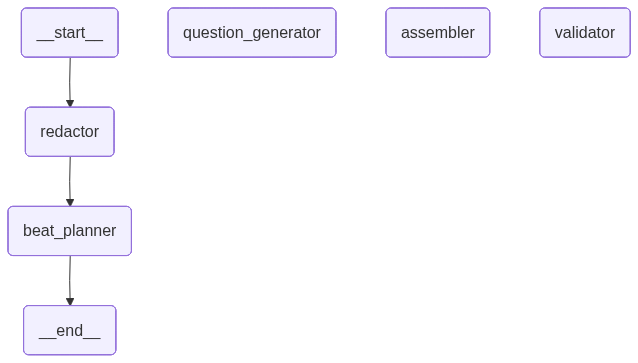

In [ ]:
builder = StateGraph(PipelineState)

builder.add_node("redactor", make_redactor_node())
builder.add_node("beat_planner", beat_planner_node)
builder.add_node("question_generator", question_generator_worker)
builder.add_node("assembler", assembler_node)
builder.add_node("validator", validator_node)

builder.add_edge(START, "redactor")
builder.add_edge("redactor", "beat_planner")

builder.add_edge("question_generator", "assembler")
builder.add_edge("assembler", "validator")
builder.add_edge("validator", END)

graph = builder.compile()

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))
